In [12]:
import rasterio
from rasterio.plot import show
import os
import sys
from rasterio.mask import mask

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [13]:
root_fp = "/nfs/a319/gy17m2a/PhD/"
# os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from PDF_plotting_functions import *
# sys.path.insert(0, root_fp + 'Scripts/Regridding')
# from Regridding_functions import *
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_geometry_functions import *

# Define ensemble member numbers
ems = ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '15']
# Define time period
timeperiod = 'Baseline'
# define whether to trim to JJA
jja_status = 'jja'

In [14]:
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:27700'})
leeds_at_centre_gdf

,geometry
0,"POLYGON ((391061.670 470497.324, 472261.556 47..."


In [15]:
fp = r"../../../datadir/NimRod_Processed/2004/metoffice-c-band-rain-radar_uk_20040406_1km-composite.tiff"
img = rasterio.open(fp)
show(img)

RasterioIOError: ../../../datadir/NimRod_Processed/2004/metoffice-c-band-rain-radar_uk_20040406_1km-composite.tiff: No such file or directory

In [14]:
print(img.count)
print(img.height, img.width)
print(img.crs)

1
775 640
EPSG:27700


In [11]:
with rasterio.open(fp) as src:
    catchment_gdf=leeds_at_centre_gdf.to_crs(src.crs)
    out_image, out_transform=mask(src,leeds_at_centre_gdf.geometry,crop=True)
    out_meta=src.meta.copy() # copy the metadata of the source DEM

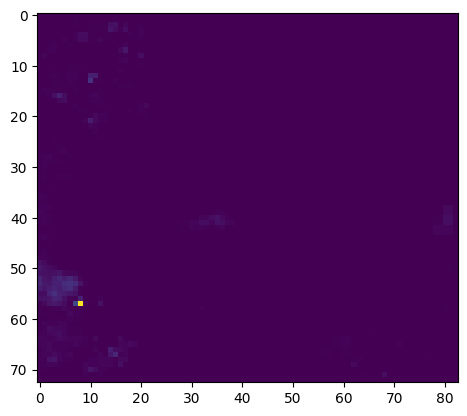

array([[[0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
        ...,
        [0.     , 0.03125, 0.     , ..., 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ]]],
      dtype=float32)

In [29]:
show(out_image)
out_image

In [ ]:
def save_clipped_to_gdf(input_fp catchment_gdf, output_fp):
    with rasterio.open(input_fp) as src:
        catchment_gdf=catchment_gdf.to_crs(src.crs)
        # print(Vector.crs)
        out_image, out_transform=mask(src,catchment_gdf.geometry,crop=True)
        out_meta=src.meta.copy() # copy the metadata of the source DEM

    out_meta.update({"driver":"Gtiff", "height":out_image.shape[1], # height starts with shape[1]
        "width":out_image.shape[2], # width starts with shape[2]
        "transform":out_transform
    })

    with rasterio.open(fp,'w',**out_meta) as dst:
        dst.write(out_image)

In [27]:
import glob
import numpy as np
import rasterio

all_files = glob.glob('../../../../datadir/NimRod_Processed/2004/*.tiff')

# Create an initial array
with rasterio.open(all_files[0]) as src:
    catchment_gdf=leeds_at_centre_gdf.to_crs(src.crs)
    result_array, out_transform=mask(src,leeds_at_centre_gdf.geometry,crop=True)
    result_profile = src.profile 

# Add on the rest one at a time
for f in all_files[1:]:
    with rasterio.open(f) as src:
        catchment_gdf=leeds_at_centre_gdf.to_crs(src.crs)
        this_result_array, out_transform=mask(src,leeds_at_centre_gdf.geometry,crop=True)
        # Only sum the arrays if the profiles match. 
        assert result_profile == src.profile, 'stopping, file {} and  {} do not have matching profiles'.format(all_files[0], f)
        result_array = result_array + this_result_array
        
with rasterio.open('../../../../datadir/NimRod_Processed/2004/Result_raster.tif', 'w', **result_profile) as dst:
        dst.write(result_array, indexes=[1])

In [24]:
this_result_array

array([[[0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
        ...,
        [0.     , 0.03125, 0.     , ..., 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ]]],
      dtype=float32)

In [28]:
result_array

array([[[0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
        ...,
        [0.     , 0.03125, 0.0625 , ..., 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.03125, ..., 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ]]],
      dtype=float32)